# Tutorial on Bitcoin Transaction Data

In this notebook, we demonstrate how to access the original transaction data tables and combine them with actor identification from address clustering and external sources.

Let's take a look at an example Bitcoin transaction: https://www.blockchain.com/btc/tx/868704537c0aa86babb057effe80dbb27efb4179375fdfa1c2b8d2af2ae84fc1

Transactions are collected into a block: https://www.blockchain.com/btc/block/741014

### Dataset

The dataset consists of five data tables:
1. Block headers *(blocks.csv)*
2. Transaction headers *(transactions.csv)*
3. List of inputs for each transaction *(inputs.csv)*
4. List of outputs for each transaction *(outputs.csv)*
5. Addresses *(addresses.csv)*

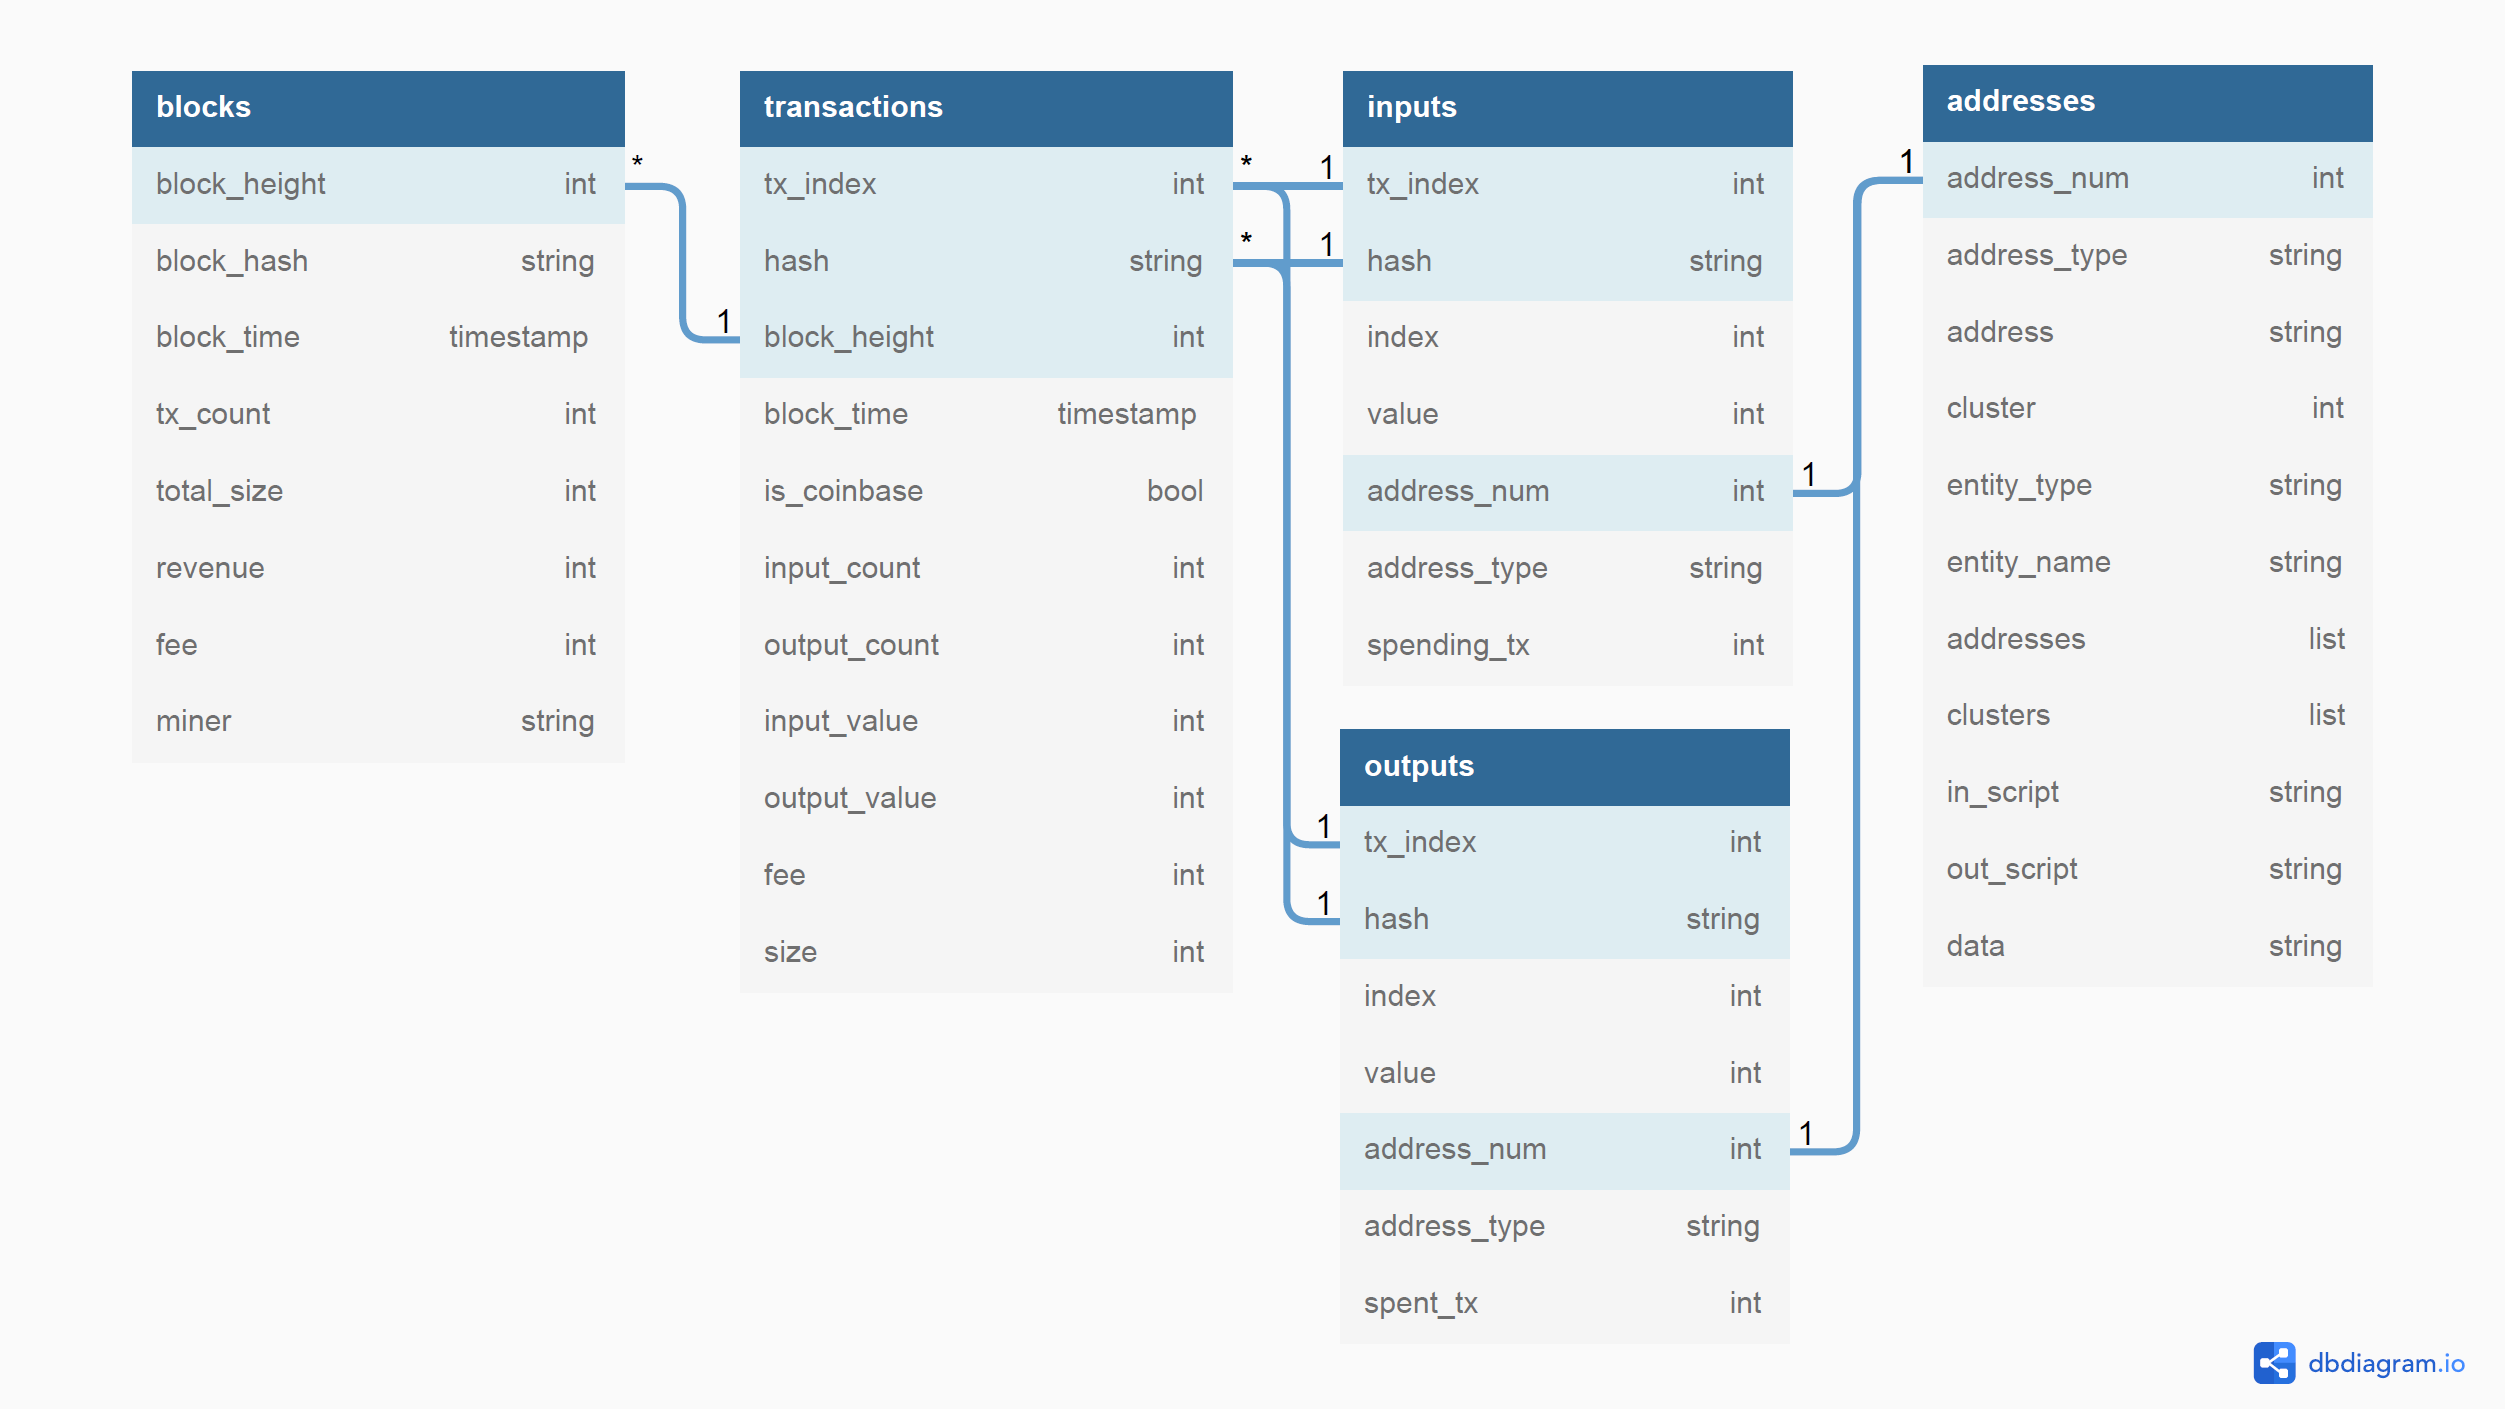

In [2]:
import pandas as pd
import networkx as nx

#from google.colab import drive
#drive.mount('/content/drive')

path = 'http://cazabetremy.fr/datasets/bitcoin2days/'

### 1. Block Headers

A block contains a list of transactions mined by the miner.

*   ``block_height``: the block height.
*   ``block_hash``: the hash of the block
*   ``block_time``: the timestamp of the block (UTC)
*   ``tx_count``: the number of transactions in the block
*   ``total_size``: the total size of the block in bytes
*   ``revenue``: the total mining reward (block reward + total transaction fees) in satoshi
*   ``fee``: the total transaction fees in satoshi
*   ``miner``: the name of the miner who found the block

**Note: 1 satoshi = 0.00000001 BTC**

In [3]:
blocks = pd.read_csv(path + 'blocks.csv')
blocks

,block_height,block_hash,block_time,tx_count,total_size,revenue,fee,miner
0,419856,00000000000000000117c76ecec8f7a649204d51ea3312...,2016-07-08 16:32:24,1168,843772,2530622577,30622577,BitFury
1,419857,000000000000000001a3fe86a2ef0ea6d6a5e8157f73cf...,2016-07-08 16:36:20,835,984109,2526427961,26427961,AntPool
2,419858,00000000000000000061afd6ac77275eea16e5fda1efaf...,2016-07-08 16:59:49,2761,998122,2589929096,89929096,BitFury
3,419859,000000000000000001169b81a1e01d77dc8b3c21f78918...,2016-07-08 17:04:36,1661,998165,2543960035,43960035,AntPool
4,419860,00000000000000000457b5cc6d21a51fc174991e650443...,2016-07-08 17:33:38,2970,999958,2580746174,80746174,F2Pool
...,...,...,...,...,...,...,...,...
284,420140,0000000000000000024428d27e15515293a83dc6501fb2...,2016-07-10 14:34:27,884,411468,1271130111,21130111,BW.COM
285,420141,0000000000000000022864f6cc51370f8c559d0bb423f6...,2016-07-10 14:40:16,777,391767,1278450551,28450551,SlushPool
286,420142,0000000000000000029781863236a2841b2d6f4a59ce14...,2016-07-10 14:44:12,537,234233,1261751462,11751462,BTCC Pool
287,420143,000000000000000001779d4ba6f08245f3d47a8512bdb8...,2016-07-10 14:45:16,250,979168,1258901992,8901992,KanoPool


In [4]:
# min and max block heights
blocks['block_height'].describe()

count       289.000000
mean     420000.000000
std          83.571327
min      419856.000000
25%      419928.000000
50%      420000.000000
75%      420072.000000
max      420144.000000
Name: block_height, dtype: float64

### 2. Addresses

To identify important actor among transaction records, we provide the address dataset that include the following information:
*   ``address``: the address hash
*   ``address_type``: the type of an address (i.e., pubkey, pubkeyhash, scripthash, multisig, nulldata, nonstandard, witness_v0_scripthash, and witness_v0_keyhash, witness_unknown)
*   ``cluster``: the id of a group of addresses that are likely to belong to the same user. We use clustering heuristic in *BlockSci* which assume that address in the input transactions are the same actor.
*   ``entity_name``: the name of a known actor identified from the external dataset. In this case, we identify the address of known actors from *WalletExplorer.com*.
*   ``entity_type``: the type of a known actor (i.e., exchange, mining, wallet, service, market, mixer, lending, gambling, scam, and historic)

Note: Multi-signature addresses consists of the list of addresses (``addresses``) and list of clusters (``clusters``).

In [5]:
addrs = pd.read_csv(path + 'addresses.csv', low_memory=False)

In [6]:
# Get address of all known actors
addrs[~addrs['entity_name'].isna()]

,address_num,address_type,address,cluster,data,addresses,clusters,entity_name,entity_type
0,20803569,pubkeyhash,1DrK44np3gMKuvcGeFVv9Jk67zodP52eMu,107718037.0,NaN,NaN,NaN,BitFury,mining
5,2106015,pubkeyhash,1STRonGxnFTeJiA7pgyneKknR29AwBM77,99109203.0,NaN,NaN,NaN,StrongCoin.com-fee,wallet
14,8661111,scripthash/multisig2of3,3QVGJQgRZE8B7mRH3tjBDbJnQrGQbN1Gg3,119129.0,NaN,NaN,NaN,Cryptopay.me,service
32,48717882,pubkeyhash,18F8FAKN6F7TKeVnm13ua81BHHHwtkwAak,108349678.0,NaN,NaN,NaN,NitrogenSports.eu,gambling
55,112057658,pubkeyhash,1Dg4waZjq7kePkhYNugb4v91YNCz6ouJ7c,107786284.0,NaN,NaN,NaN,BTCC Pool,mining
...,...,...,...,...,...,...,...,...,...
720561,171834527,pubkeyhash,18pbdyTt2kY6FcXJnBJVZZczXR1Hwr7Gqo,109376351.0,NaN,NaN,NaN,999Dice.com,gambling
720562,173936486,pubkeyhash,1GLcjXs68ftGvv9HGg4RNfpuQpc7R46de6,109376351.0,NaN,NaN,NaN,999Dice.com,gambling
720565,173936487,pubkeyhash,1AZYnW2oeUrTtoRJMnrDqxALdbvBLMkPf4,109376351.0,NaN,NaN,NaN,999Dice.com,gambling
720587,173936500,pubkeyhash,1MDoMBLrwvfcgdZDwWfHfsoFiHD2DUvqrv,12497384.0,NaN,NaN,NaN,CoinPayments.net,service


In [7]:
# Get multisignature addresses
addrs[~addrs['addresses'].isna()]

,address_num,address_type,address,cluster,data,addresses,clusters,entity_name,entity_type
141249,8306658,multisig1of3,NaN,NaN,NaN,"['1Gb5Phsw7sQA9MZMB7rKnqXMMrgo2JF5R3', '1A358B...","[182745220, 182853713, 182853714]",NaN,NaN
141250,8306659,multisig1of2,NaN,NaN,NaN,"['1Gb5Phsw7sQA9MZMB7rKnqXMMrgo2JF5R3', '1Fkkr1...","[182745220, 182853715]",NaN,NaN
142711,8306737,multisig1of3,NaN,NaN,NaN,"['1Gb5Phsw7sQA9MZMB7rKnqXMMrgo2JF5R3', '1ED8Hv...","[182745220, 182854210, 182854211]",NaN,NaN
142712,8306738,multisig1of3,NaN,NaN,NaN,"['1Gb5Phsw7sQA9MZMB7rKnqXMMrgo2JF5R3', '17TFiu...","[182745220, 182854212, 182854213]",NaN,NaN
219673,8315607,multisig2of3,NaN,NaN,NaN,"['18GJ5FNFY28B6qxoGG4bo19cGFXZiHrH1Z', '18EeLi...","[182881718, 182863425, 182881717]",NaN,NaN
459946,8337613,multisig2of2,NaN,NaN,NaN,"['18Cvgnq88b2HnrkR6L5qMEmZp8ZTurAHSs', '1JTUdX...","[183004749, 183004750]",NaN,NaN
513519,5237627,multisig3of3,NaN,NaN,NaN,"['1FcjcJ5gMRBpKjhYRAxmb64A34TrqUWbFC', '17pFcx...","[167457423, 167457422, 167458880]",NaN,NaN
519217,8348658,multisig1of2,NaN,NaN,NaN,"['1FwADyEvdvaLNxjN1v3q6tNJCgHEBuABrS', '1792AG...","[127925546, 183052384]",NaN,NaN
720650,8373447,multisig1of3,NaN,NaN,NaN,"['1PexU18WvWPTcEFWpFkzRdm1qXWShoeBan', '12xeyA...","[183177929, 183177930, 132278807]",NaN,NaN
720651,8373448,multisig1of3,NaN,NaN,NaN,"['1HgBEFp4SyFcBWtJChFrozPDLBhdhh7pS6', '1FL3PH...","[183177931, 183177932, 132278807]",NaN,NaN


### 3. Transactions

A transaction records the transfer of Bitcoin from inputs to outputs.

*   ``tx_index``: the identification of the transaction
*   ``hash``: the hash of the transaction
*   ``block_height``: the block height of the block containing the transaction
*   ``block_time``: the timestamp of the block containing the transaction (UTC)
*   ``is_coinbase``: Is it a coinbase (generating new coins) transaction?
*   ``input_count``: Number of inputs
*   ``output_count``: Number of outputs
*   ``input_total``: Total input value in satoshi
*   ``output_total``: Total output value in satoshi
*   ``fee``: Transaction fee in satoshi
*   ``size``: The size of this transaction in bytes

In [8]:
txs = pd.read_csv(path + 'transactions.csv')

In [9]:
txs

,tx_index,hash,block_height,block_time,is_coinbase,input_count,output_count,input_value,output_value,fee,size
0,141192741,684227c33ade9c184bef6715019249a896366f5b456498...,419856,2016-07-08 16:32:24,True,0,1,0,2530622577,0,120
1,141192742,e4644bd2cf47eaad487d94b8fe779139667657a2d80e72...,419856,2016-07-08 16:32:24,False,1,2,628379483,628179483,200000,257
2,141192743,1048bdb6ac58b9b0068237c5176861079b2f25de7f0549...,419856,2016-07-08 16:32:24,False,1,3,4000000,3900000,100000,292
3,141192744,c904560c5d417c7e61451e37df78c17f3a2cf25dc4eec9...,419856,2016-07-08 16:32:24,False,2,1,56810000,56710000,100000,339
4,141192745,3aaea478e7b4b6b048c913aa9cba94e73d7dad1cd8bfe0...,419856,2016-07-08 16:32:24,False,2,2,391363040,391263040,100000,371
...,...,...,...,...,...,...,...,...,...,...,...
349727,141542468,fe021d34bea767a3a9060824d106af06290bd3f226d442...,420144,2016-07-10 14:50:28,False,1,2,163039,161334,1705,225
349728,141542469,d758a924085eefe250569241ed22928c0eba760408f2cd...,420144,2016-07-10 14:50:28,False,3,6,4300000,4295046,4954,655
349729,141542470,395c8ea5bdfff6b8345898806942bcec69b79773a1642f...,420144,2016-07-10 14:50:28,False,1,2,162986,161281,1705,226
349730,141542471,d1dcfec36028476c6d8962b6b98abbd7380c3e78595471...,420144,2016-07-10 14:50:28,False,2,2,124320,121499,2821,373


In [10]:
# List of all coinbase transactions
txs[txs['is_coinbase']]

,tx_index,hash,block_height,block_time,is_coinbase,input_count,output_count,input_value,output_value,fee,size
0,141192741,684227c33ade9c184bef6715019249a896366f5b456498...,419856,2016-07-08 16:32:24,True,0,1,0,2530622577,0,120
1168,141193909,59c56774a8421c2143922fe75ab47511ce898d02f3e999...,419857,2016-07-08 16:36:20,True,0,1,0,2526427961,0,129
2003,141194744,9b8fa84c5d381772dc217e438f3b81aeb0222c968d75d8...,419858,2016-07-08 16:59:49,True,0,1,0,2589929096,0,120
4764,141197505,f59d720254b3059db5b397b25312d5e8edb7d7112464f8...,419859,2016-07-08 17:04:36,True,0,1,0,2543960035,0,128
6425,141199166,05225402b98146e38eae1b7f5ef60e1b069de6e10b2898...,419860,2016-07-08 17:33:38,True,0,1,0,2580746174,0,185
...,...,...,...,...,...,...,...,...,...,...,...
346597,141539338,1b4d3e6515e3914ca9296c14bafbfa55306ed34200eec1...,420140,2016-07-10 14:34:27,True,0,1,0,1271130111,0,148
347481,141540222,4431bb8df17afb466da15364f988b52d26e47ae2ede6f7...,420141,2016-07-10 14:40:16,True,0,1,0,1278450551,0,154
348258,141540999,31dd9e756f7f4548d2027f4516e74798f742b6184e6c41...,420142,2016-07-10 14:44:12,True,0,1,0,1261751462,0,185
348795,141541536,eb21d45e5995d7689a3f2fb29ea83b2211b15d4a76094e...,420143,2016-07-10 14:45:16,True,0,2,0,1258901992,0,168


Each transaction contains a list of input and output transactions.

*   ``tx_index``: the identification of the transaction
*   ``hash``: the hash of the transaction
*   ``index``: index of the input/output in the transaction 
*   ``value``: Monetary value of the input/output in satoshi
*   ``address_num``: address number of the input/output recipient.
*   ``type``: type of the address (pubkey, pubkeyhash, scripthash, multisig, nulldata, etc.)
*   For the input table, ``spent_tx``: the index of the transaction that this input spent
*   For the output table, ``spending_tx``: the index of the tranasction which spent this output or ``None`` if it is unspent

#### 3.1 Inputs

In [11]:
inps = pd.read_csv(path + 'inputs.csv')
inps

,tx_index,hash,index,value,address_num,address_type,spent_tx
0,141192742,e4644bd2cf47eaad487d94b8fe779139667657a2d80e72...,0,628379483,47665646,Pay to pubkey hash,140664526
1,141192743,1048bdb6ac58b9b0068237c5176861079b2f25de7f0549...,0,4000000,173405976,Pay to pubkey hash,141180665
2,141192744,c904560c5d417c7e61451e37df78c17f3a2cf25dc4eec9...,0,21061500,173429801,Pay to pubkey hash,141190645
3,141192744,c904560c5d417c7e61451e37df78c17f3a2cf25dc4eec9...,1,35748500,173429801,Pay to pubkey hash,141190603
4,141192745,3aaea478e7b4b6b048c913aa9cba94e73d7dad1cd8bfe0...,0,391013040,46665353,Pay to pubkey hash,141152837
...,...,...,...,...,...,...,...
847502,141542472,ca6ab2aa773e495758a2fccf352dbccd2fefbb601d07fc...,0,6320,85082659,Pay to pubkey hash,87503967
847503,141542472,ca6ab2aa773e495758a2fccf352dbccd2fefbb601d07fc...,1,5470,85082659,Pay to pubkey hash,89842741
847504,141542472,ca6ab2aa773e495758a2fccf352dbccd2fefbb601d07fc...,2,5470,85082659,Pay to pubkey hash,81895376
847505,141542472,ca6ab2aa773e495758a2fccf352dbccd2fefbb601d07fc...,3,5470,85082659,Pay to pubkey hash,75598098


In [12]:
# Get all inputs of the transaction 4ebf9a9fabd08a66e05e2420fe65596c03852e5b022ca952a6a3676c11f02993
inps[inps['hash'] == '4ebf9a9fabd08a66e05e2420fe65596c03852e5b022ca952a6a3676c11f02993']

,tx_index,hash,index,value,address_num,address_type,spent_tx
149557,141262434,4ebf9a9fabd08a66e05e2420fe65596c03852e5b022ca9...,0,600000,114106976,Pay to pubkey hash,141261491
149558,141262434,4ebf9a9fabd08a66e05e2420fe65596c03852e5b022ca9...,1,893725,168696275,Pay to pubkey hash,141261182
149559,141262434,4ebf9a9fabd08a66e05e2420fe65596c03852e5b022ca9...,2,7821886,159447279,Pay to pubkey hash,141260484
149560,141262434,4ebf9a9fabd08a66e05e2420fe65596c03852e5b022ca9...,3,9590731,159447279,Pay to pubkey hash,141260915
149561,141262434,4ebf9a9fabd08a66e05e2420fe65596c03852e5b022ca9...,4,11706294,157681814,Pay to pubkey hash,141260957
149562,141262434,4ebf9a9fabd08a66e05e2420fe65596c03852e5b022ca9...,5,15000000,139093998,Pay to pubkey hash,141261048
149563,141262434,4ebf9a9fabd08a66e05e2420fe65596c03852e5b022ca9...,6,55095454,159769924,Pay to pubkey hash,141260924
149564,141262434,4ebf9a9fabd08a66e05e2420fe65596c03852e5b022ca9...,7,159000000,130439828,Pay to pubkey hash,141261471
149565,141262434,4ebf9a9fabd08a66e05e2420fe65596c03852e5b022ca9...,8,200000000,70038492,Pay to pubkey hash,141261160
149566,141262434,4ebf9a9fabd08a66e05e2420fe65596c03852e5b022ca9...,9,1688662191,165484672,Pay to pubkey hash,141260429


#### 3.2 Outputs

In [13]:
outs = pd.read_csv(path + 'outputs.csv')
outs

,tx_index,hash,index,value,address_num,address_type,spending_tx
0,141192741,684227c33ade9c184bef6715019249a896366f5b456498...,0,2530622577,20803569,Pay to pubkey hash,148104669.0
1,141192742,e4644bd2cf47eaad487d94b8fe779139667657a2d80e72...,0,400000000,168251500,Pay to pubkey hash,141198794.0
2,141192742,e4644bd2cf47eaad487d94b8fe779139667657a2d80e72...,1,228179483,47665646,Pay to pubkey hash,141366681.0
3,141192743,1048bdb6ac58b9b0068237c5176861079b2f25de7f0549...,0,3400000,173432615,Pay to pubkey hash,141199172.0
4,141192743,1048bdb6ac58b9b0068237c5176861079b2f25de7f0549...,1,400000,2106015,Pay to pubkey hash,157749816.0
...,...,...,...,...,...,...,...
964764,141542471,d1dcfec36028476c6d8962b6b98abbd7380c3e78595471...,0,21499,173936535,Pay to pubkey hash,142466738.0
964765,141542471,d1dcfec36028476c6d8962b6b98abbd7380c3e78595471...,1,100000,173936532,Pay to pubkey hash,143001011.0
964766,141542472,ca6ab2aa773e495758a2fccf352dbccd2fefbb601d07fc...,0,5468,85082659,Pay to pubkey hash,NaN
964767,141542472,ca6ab2aa773e495758a2fccf352dbccd2fefbb601d07fc...,1,7800,8373447,Multisig,NaN


In [14]:
# Get all inputs of the transaction 4ebf9a9fabd08a66e05e2420fe65596c03852e5b022ca952a6a3676c11f02993
outs[outs['hash'] == '4ebf9a9fabd08a66e05e2420fe65596c03852e5b022ca952a6a3676c11f02993']

,tx_index,hash,index,value,address_num,address_type,spending_tx
204980,141262434,4ebf9a9fabd08a66e05e2420fe65596c03852e5b022ca9...,0,13080146,42252786,Pay to pubkey hash,141292220.0
204981,141262434,4ebf9a9fabd08a66e05e2420fe65596c03852e5b022ca9...,1,14040000,100478985,Pay to pubkey hash,142717354.0
204982,141262434,4ebf9a9fabd08a66e05e2420fe65596c03852e5b022ca9...,2,15830000,134845866,Pay to pubkey hash,146612013.0
204983,141262434,4ebf9a9fabd08a66e05e2420fe65596c03852e5b022ca9...,3,45204179,173529041,Pay to pubkey hash,141282633.0
204984,141262434,4ebf9a9fabd08a66e05e2420fe65596c03852e5b022ca9...,4,81859100,132305328,Pay to pubkey hash,141265332.0
204985,141262434,4ebf9a9fabd08a66e05e2420fe65596c03852e5b022ca9...,5,119642870,703394,Pay to script hash,147942805.0
204986,141262434,4ebf9a9fabd08a66e05e2420fe65596c03852e5b022ca9...,6,200000000,173529042,Pay to pubkey hash,141292220.0
204987,141262434,4ebf9a9fabd08a66e05e2420fe65596c03852e5b022ca9...,7,255480000,173245732,Pay to pubkey hash,141269022.0
204988,141262434,4ebf9a9fabd08a66e05e2420fe65596c03852e5b022ca9...,8,1045219004,7849523,Pay to script hash,141531615.0
204989,141262434,4ebf9a9fabd08a66e05e2420fe65596c03852e5b022ca9...,9,357879846,165484672,Pay to pubkey hash,141262435.0


### 4. Bitcoin Transaction Network

From the Bitcoin transaction data, many types of networks can be constructed, including transaction network, address network, and user (= actor, entity) network.

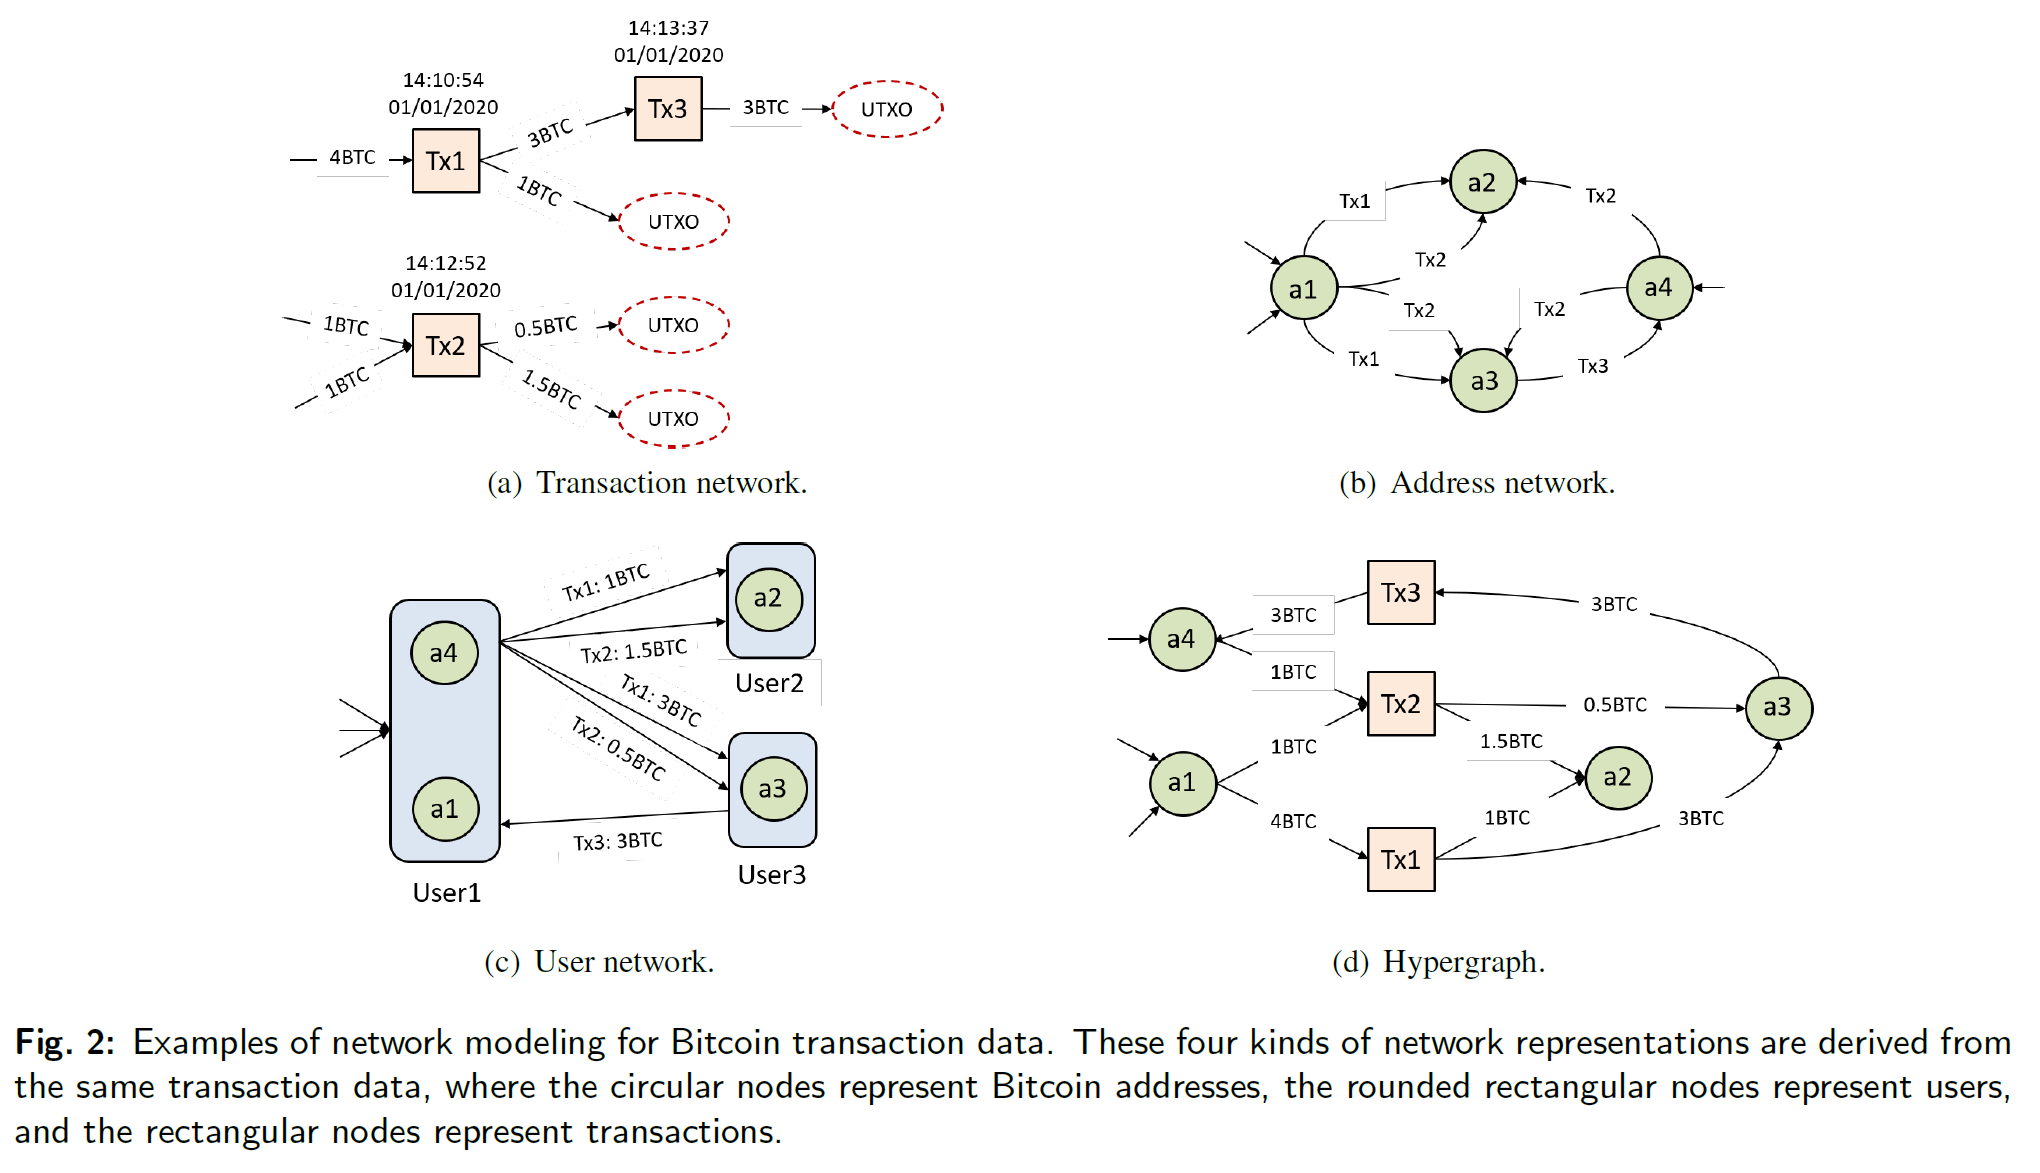

Source: Wu et al. "Analysis of cryptocurrency transactions from a network perspective: An overview." Journal of Network and Computer Applications 190 (2021): 103139. https://arxiv.org/pdf/2011.09318.pdf

#### 4.1 Transaction Network

We can model transaction network as a directed acyclic graph (DAG) with multi-edges and no-self loop.

*   Node = a transaction (attributes: timestamp)
*   Edge = an input / an output (attributes: address/entity, amount)

In [15]:
# Create an edge list dataframe
inps2 = inps[['spent_tx', 'tx_index', 'address_num', 'value']].rename(columns={'spent_tx': 'from_tx', 'tx_index': 'to_tx'})
outs2 = outs[['tx_index', 'spending_tx', 'address_num', 'value']].rename(columns={'tx_index': 'from_tx', 'spending_tx': 'to_tx'})
edges = inps2.merge(outs2, how='inner', on=['from_tx', 'to_tx'], suffixes=('', '_out'))

In [16]:
edges

,from_tx,to_tx,address_num,value,address_num_out,value_out
0,141192749,141192750,173432625,16376390000,173432625,16376390000
1,141192750,141192755,173432626,16269430000,173432626,16269430000
2,141192755,141192756,173432633,16233880000,173432633,16233880000
3,141192756,141192757,173432634,16221560000,173432634,16221560000
4,141192757,141192758,173432635,16145700000,173432635,16145700000
...,...,...,...,...,...,...
2430533,141521961,141542469,173912928,1450000,173912928,1450000
2430534,141526528,141542469,173917911,1450000,173917911,1450000
2430535,141541689,141542470,131629760,162986,131629760,162986
2430536,141542470,141542471,173936534,61281,173936534,61281


In [17]:
# Add edge list from pandas dataframe
G = nx.from_pandas_edgelist(edges, 'from_tx', 'to_tx', ['address_num', 'value'], 
                        create_using=nx.MultiDiGraph)

In [18]:
nx.info(G)

/var/folders/j8/987m6x9x2dd5j9rz_30l06840000gn/T/ipykernel_32296/1064119803.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G)


'MultiDiGraph with 327989 nodes and 2430538 edges'

In [19]:
nx.is_directed_acyclic_graph(G)

True

In [20]:
G[141521961][141542469]

AtlasView({0: {'address_num': 173912928, 'value': 1450000}})

In [21]:
# Add node attributes
nodes = txs[['tx_index', 'hash', 'block_time', 'fee']].set_index('tx_index').to_dict(orient='index')

for tx_index, data in nodes.items():
  G.add_node(tx_index, hash=data['hash'], time=data['block_time'], fee=data['fee'])

In [22]:
G.nodes[141521961]

{'hash': 'f0e6cc425777f30a1c4dd11d76bdbfb581f7871e655917a098702faa55092733',
 'time': '2016-07-10 12:16:55',
 'fee': 13277}

### 4.2 Address/Actor Network

Remy will explain it!